# Simulation d'un modèle SEIR

Inspiré de https://institutefordiseasemodeling.github.io/Documentation/general/model-seir.html et https://www.youtube.com/watch?v=wEvZmBXgxO0

In [1]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import random, math

## Modèle standard avec coefficients constants

In [37]:
# Définition du modèle
# Ici on a un beta qui varie mais est déterministe (cosinus)

def simulate_SEIR_model(y, t, beta, gamma, sigma):
    S, E, I, R = y
    N = S + E + I + R 
    
    # Equations
    dS_dt = - beta * S * I / N
    dE_dt = beta * S * I / N - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I
    
    
    return([dS_dt, dE_dt, dI_dt, dR_dt])

In [40]:
# Conditions initiales et paramètres
S0 = 10**3 # Susceptibles
E0 = 0. # Exposé
I0 = 10 # Infecté 
R0 = 0.0 # Recovered
beta = 10. # taux d'infection
sigma = 10. # taux d'incubation
gamma = 1. # taux taux de recovery

# Time vector
t = np.linspace(0, 52, 10000)

#Résultat
solution = scipy.integrate.odeint(simulate_SEIR_model, [S0, E0, I0, R0], t, args =(beta, gamma, sigma))
solution = np.array(solution)

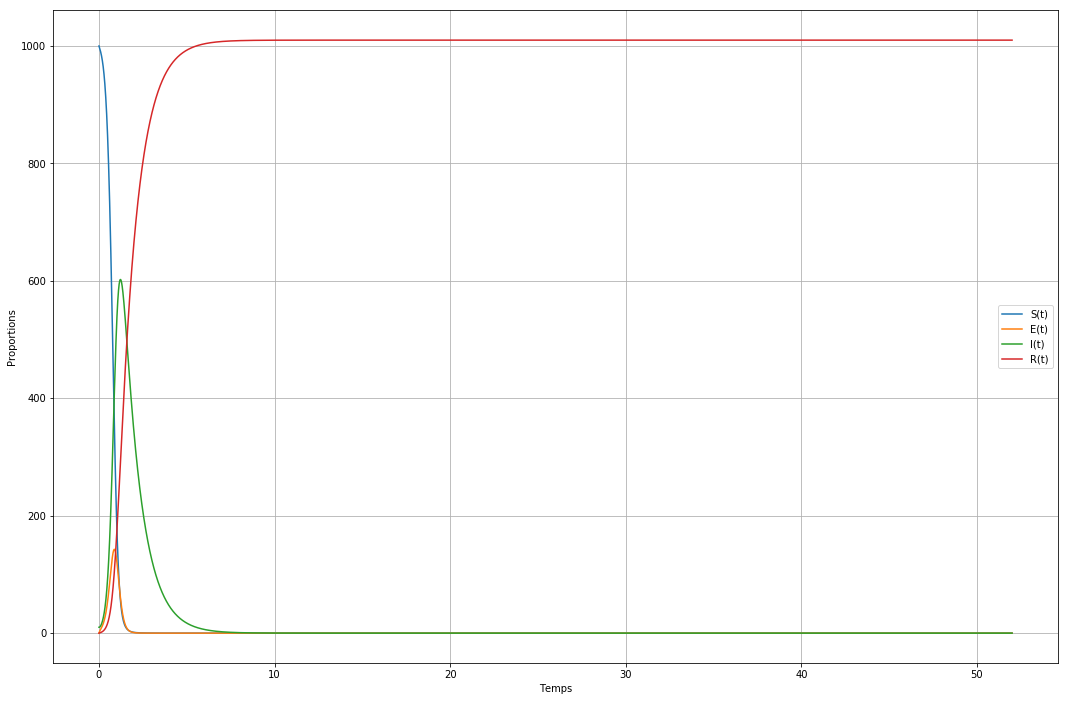

In [41]:
# Affichage des résultats

plt.figure(figsize = [18, 12])

plt.plot(t, solution[:,0], label = "S(t)")
plt.plot(t, solution[:,1], label = "E(t)")
plt.plot(t, solution[:,2], label = "I(t)")
plt.plot(t, solution[:,3], label = "R(t)")
plt.grid()
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Proportions")

plt.show()

## Modèle standard avec coefficient sigmoïde

Dans cette section, $\beta = \beta(t) = \displaystyle{\frac{1}{1+\exp(-\lambda( t+\delta))}}$ où $\lambda$ est l'intensité de la variation et $\delta$ un facteur permettant de décaler la courbe. 

In [5]:
def beta(lam, delta, t):
    return 1 - 1 / (1+math.exp(-lam * (t - delta)))

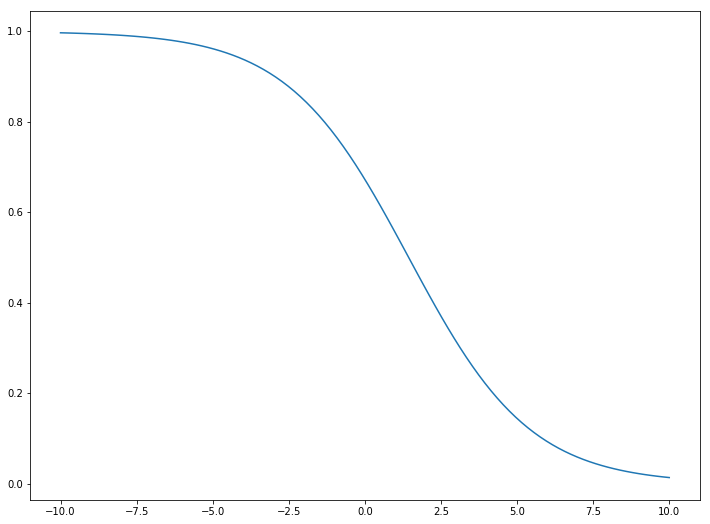

In [7]:
# Exemple
values = np.linspace(-10,10,100)
plt.plot(values, [beta(1/2, 1.44, t) for t in values])
plt.rcParams["figure.figsize"] = (12,9)
plt.show()

In [8]:
# Définition du modèle
# Ici on a un beta qui varie mais est déterministe (sigmoïde)

def simulate_sigmoid_SEIR_model(y, t, beta, gamma, sigma, lam, delta):
    S, E, I, R = y
    N = S + E + I + R 
    
    # Equations
    dS_dt = - beta(lam, delta, t) * S * I / N
    dE_dt = beta(lam, delta, t) * S * I / N - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I
    
    
    return([dS_dt, dE_dt, dI_dt, dR_dt])

In [9]:
# Conditions initiales et paramètres
S0 = 0.9 # Susceptibles
E0 = 0. # Exposé
I0 = 0.1 # Infecté 
R0 = 0.0 # Recovered

lam = 20. # Paramètre pour beta_t (rapidité du changement)
delta = 30. # paramètre pour beta_t (shift de la courbe)
sigma = .3 # taux d'incubation
gamma = 0.2 # taux taux de recovery

# Time vector
t = np.linspace(0, 52, 10000)

#Résultat
solution = scipy.integrate.odeint(simulate_sigmoid_SEIR_model, [S0, E0, I0, R0], t, args =(beta, gamma, sigma, lam, delta))
solution = np.array(solution)

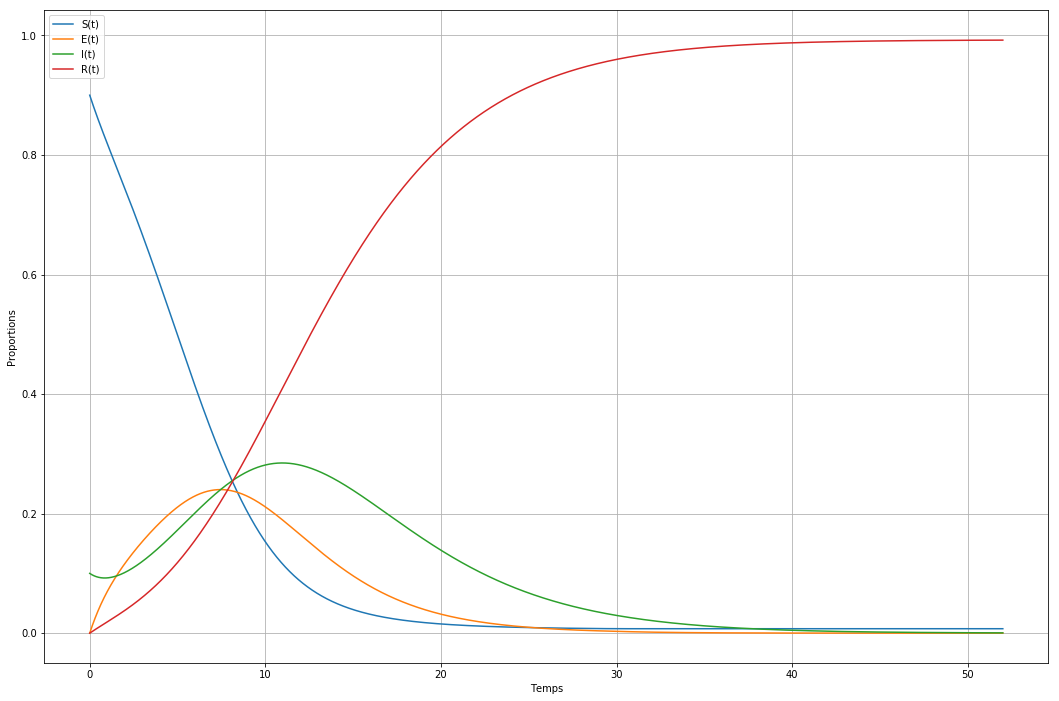

In [10]:
# Affichage des résultats

plt.figure(figsize = [18, 12])

plt.plot(t, solution[:,0], label = "S(t)")
plt.plot(t, solution[:,1], label = "E(t)")
plt.plot(t, solution[:,2], label = "I(t)")
plt.plot(t, solution[:,3], label = "R(t)")
# plt.axvline(x=delta, c = "red", linestyle='--', label = "Point d'inflexion de beta_t")
plt.grid()
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Proportions")


plt.show()

### Générer des données bruitées

In [19]:
from scipy.stats import norm

def generate_noisy_prevalence(I_t, sigma_y, bin_size, t):
    """
    Pour un vecteur donné correspondant au nombre de 
    personnes infectées, génère des observations
    bruitées tirées selon une Gaussienne
    
    Les observations sont faites en temps discret
    donc les observations sont discrétisées avec
    un pas semaine, et on prend une des valeurs
    tirées au hasard parmi l'ensemble des valeurs 
    tombant dans la boite en question.
    
    Arguments:
    - solution : un vecteur de réalisations de I_t
    - sigma_y : le bruit (entré comme std dev)
    - bin_size : longueur de la boite (en semaines)
    - t : le vecteur de temps passé en input
    """
    
    # Déduire le nombre de boites à partir de la longueur
    # du vecteur d'entrée et de la taille des boites souhaitée
    nb_days = int(np.max(t))
    nb_bins = math.floor(nb_days/bin_size) + 1
    
    # Initialisation du vecteur d'observations bruitées
    # Sous forme de liste, car si on n'a une boite vide,
    # on ne voudra pas l'utiliser. Permet de couvrir tout l'intervalle
    # avec éventuellement une taille de boite "non standard".
    noisy_values = []
    
    # Découpage du vecteur continu 
    # Vecteur des longueurs cumulées, pour "avancer" dans les indices de I_t.
    length_sequences = 0
    indices = []
    for i in range(nb_bins):
        
        # Définition la condition
        condition = [i * bin_size <= s < (i+1) * bin_size for s in t]
        # Extraire le sous vecteur qui satisfait la condition
        current_bin = np.extract(condition, t)
        
        # Dans chacune des boites, prendre une valeur de temps au hasard
        # Seulement pour les boites qui ont plus de une observation
        # sinon considérées comme vides
        if len(current_bin) > 1:
            
            # On sélectionn un indice au hasard
            index_pick = random.randrange(length_sequences, len(current_bin) + length_sequences)
            indices.append(index_pick)
            length_sequences += len(current_bin)
            # Aller chercher cette valeur de vecteur I_t
            baseline_mean = I_t[index_pick]

            # Bruiter l'observation
            y_noisy = float(norm.rvs(loc=baseline_mean, scale=sigma_y, size=1, random_state=None))
            # On ne peut pas avoir de valeurs négatives pour I_t.
            y_noisy = max(0,y_noisy)
        
            # Ajouter au vecteurs d'observations
            noisy_values.append(y_noisy)
        else: 
            continue

    return noisy_values, indices

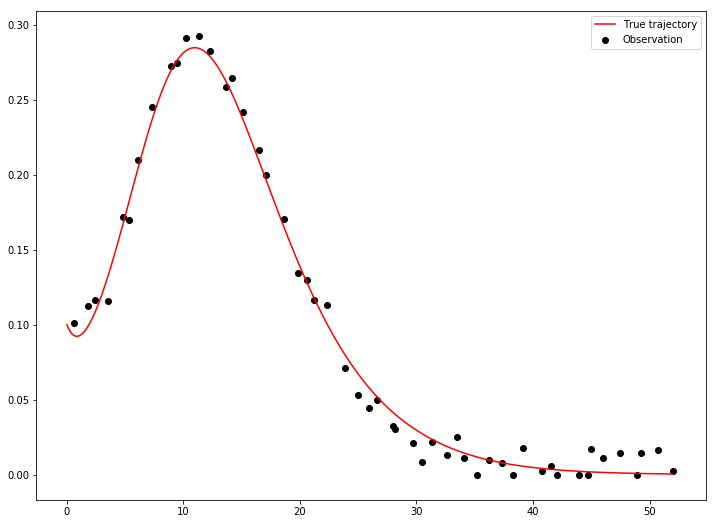

In [12]:
# Plot d'une trajectoire avec ses observations bruitées

I_t = solution[:,2]
vals, indices = generate_noisy_prevalence(I_t, .01, 1, t)

plt.plot(t, I_t, c = "red", label = "True trajectory")
plt.scatter(t[indices], vals, c = 'black', label = "Observation")
plt.legend()

plt.rcParams["figure.figsize"] = (30,18)
plt.show()

In [13]:
# Pour l'intégrale de V_t (incidence)
def generate_noisy_prevalence():
    return noisy_values, indices

## Modèle avec movement brownien

On réécrit le modèle sous la forme $\mathrm{d}x = Ax\mathrm{d}t + B\mathrm{d}W$. Les équations du modèle sont les suivantes:
$$
\begin{cases}
\frac{\mathrm{d} S_t}{\mathrm{d}t} &= -\beta_t S_t \frac{I_t}{N}\\
\frac{\mathrm{d}E_t}{\mathrm{d}t} &= \beta_t S_t \frac{I_t}{N} - \gamma E_t\\
\frac{\mathrm{d}I_t}{\mathrm{d}t} &= \gamma E_t - \sigma I_t\\
\frac{\mathrm{d} R_t}{\mathrm{d}t} &= \sigma I_t\\
x_t &= \sigma\mathrm{d}B_t
\end{cases}
$$
Et finalement, $\beta_t = h(x_t)$ où $h$ est une fonction à valeurs positives (pour éliminer les taux de contact négatifs. On considère par exemple $h(x_t) = \log \beta_t$

In [14]:
import sdeint

# Paramètres
mu, sigma, gamma = 0.1, 0.01, 0.3

# Variance pour le BM
sigma_x = 1.

# Vecteur temporel
t = np.linspace(0, 52, 10000)

# Conditions initiales
S0 = 10^5 # Susceptibles
E0 = 10^2 # Exposé
I0 = 0 # Infecté 
R0 = 0.0 # Recovered
y0 = np.array([S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

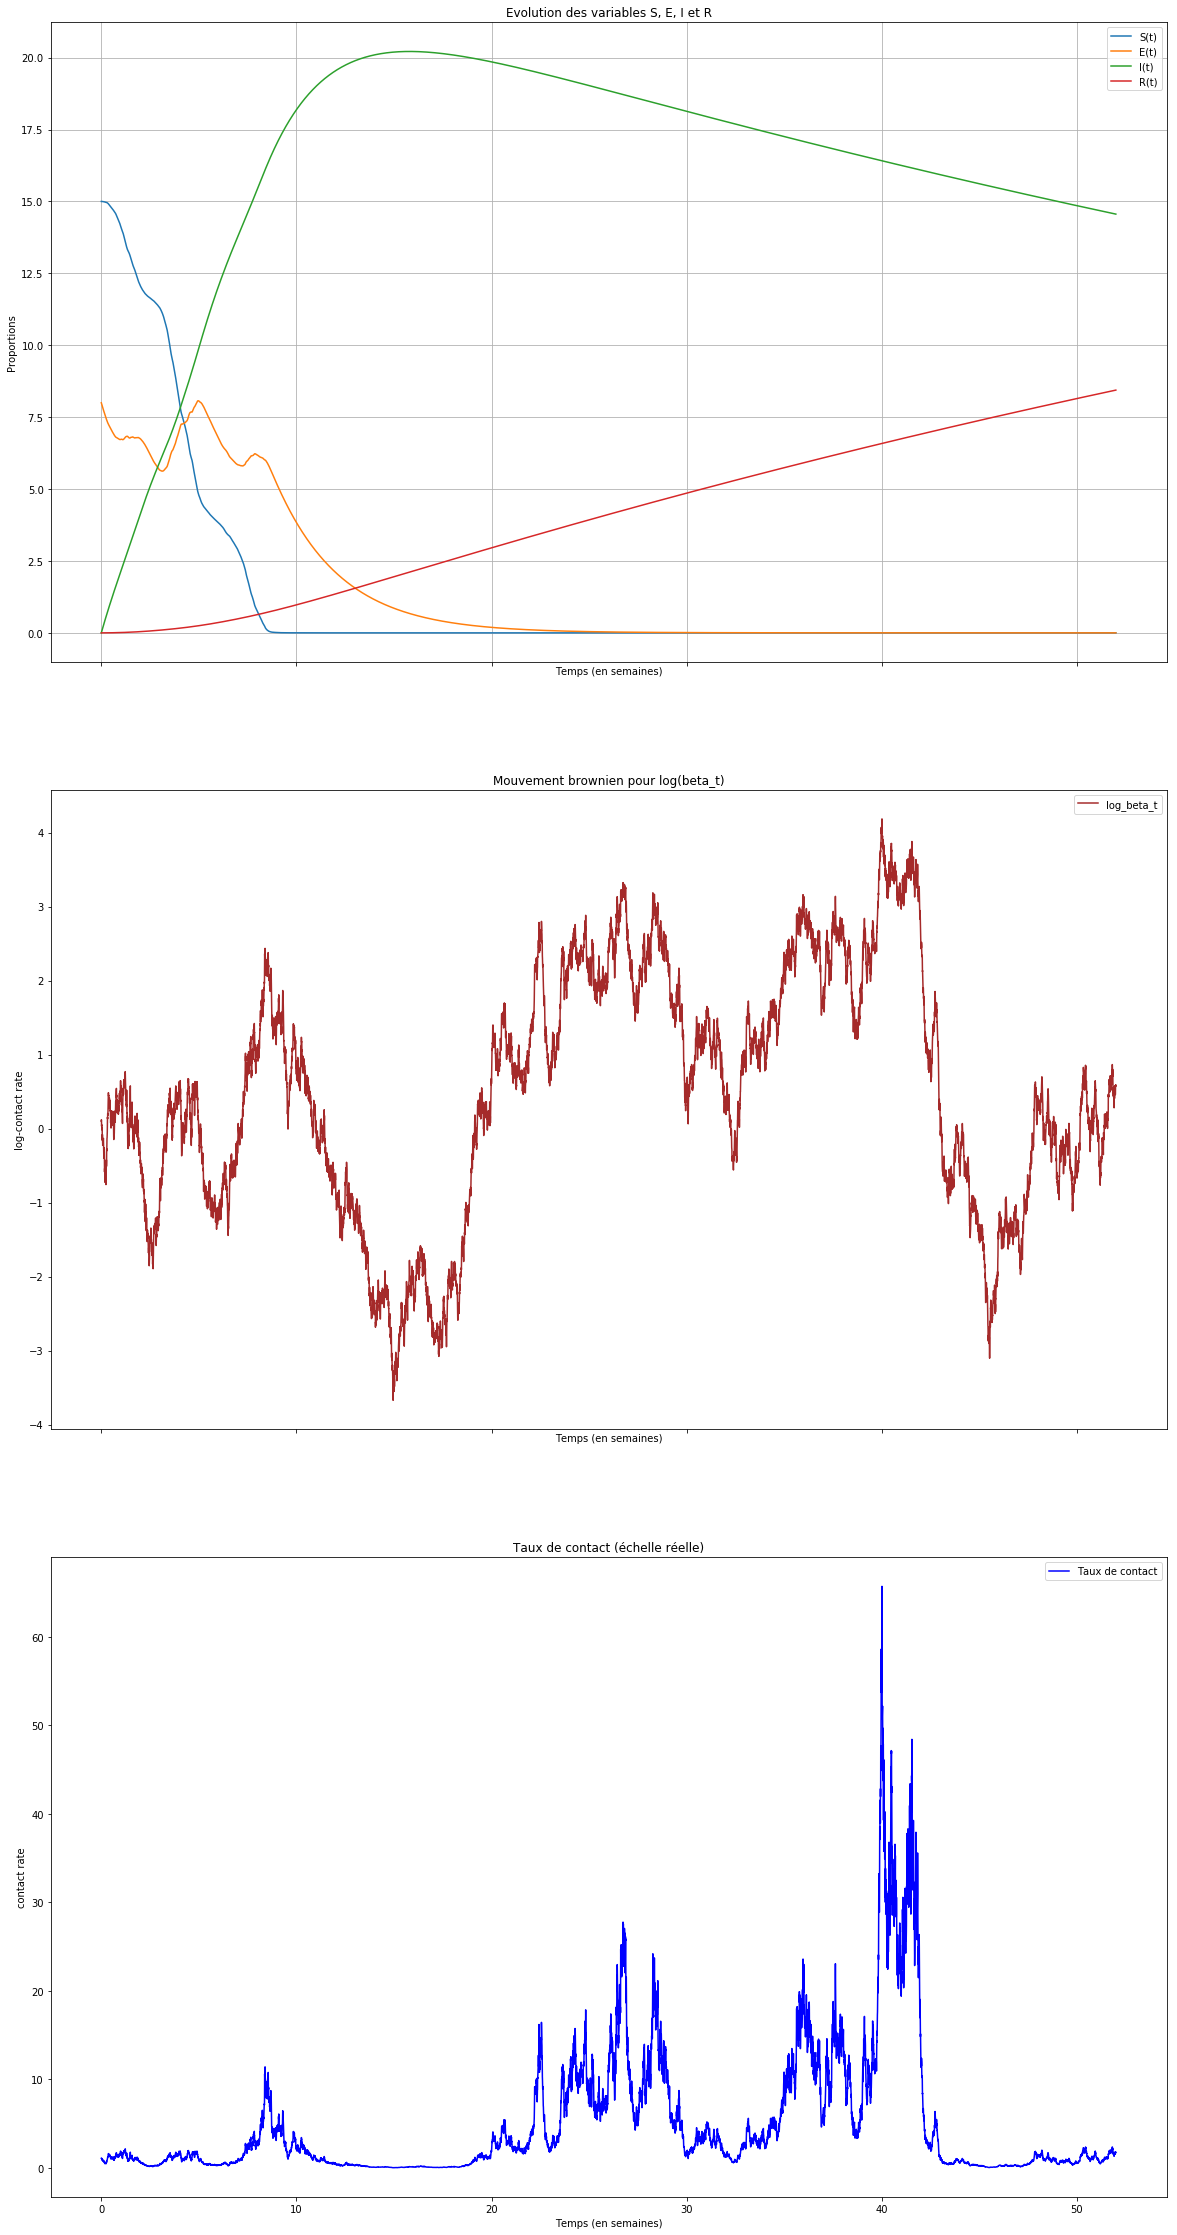

In [17]:
# Initialisation des subplots
fig, ((ax1, ax2, ax3)) = plt.subplots(3, sharex=True, sharey=False)

# Plot des variables d'état du système
ax1.plot(t, result[:,0], label = "S(t)");
ax1.plot(t, result[:,1], label = "E(t)");
ax1.plot(t, result[:,2], label = "I(t)");
ax1.plot(t, result[:,3], label = "R(t)");
ax1.grid();
ax1.legend();
ax1.set_title("Evolution des variables S, E, I et R");
ax1.set_xlabel("Temps (en semaines)");
ax1.set_ylabel("Proportions");

# Plot de la partie stochastique
ax2.plot(t, result[:,4], label = "log_beta_t", c = "brown");
ax2.set_title("Mouvement brownien pour log(beta_t)");
ax2.set_xlabel("Temps (en semaines)");
ax2.set_ylabel("log-contact rate");
ax2.legend()

# Partie stochastique, en échelle normale
ax3.plot(t, np.exp(result[:,4]), c = "blue", label = "Taux de contact")
ax3.set_title("Taux de contact (échelle réelle)")
ax3.set_xlabel("Temps (en semaines)")
ax3.set_ylabel("contact rate")
ax3.legend()

# Agrandissement de la fenêtre
plt.rcParams["figure.figsize"] = (20,40)

plt.show()

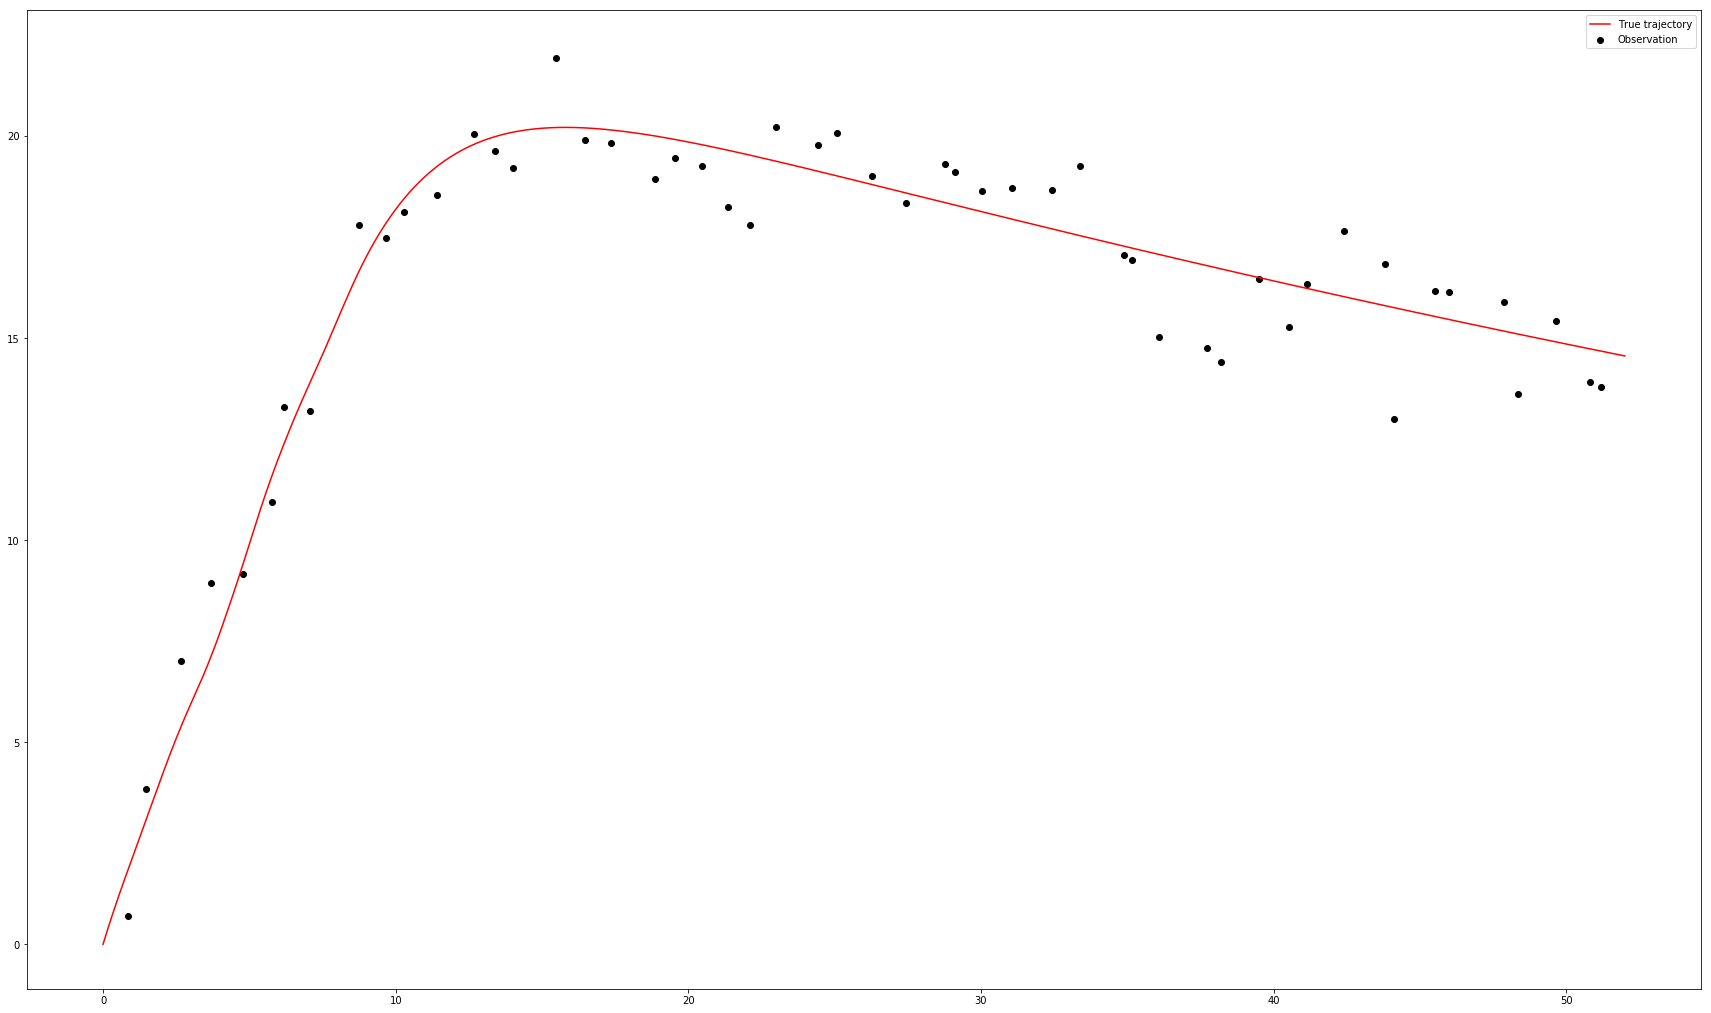

In [21]:
# Observations aléatoires pour I_t
I_t = result[:,2]
vals, indices = generate_noisy_prevalence(I_t, 1, 1, t)

plt.plot(t, I_t, c = "red", label = "True trajectory")
plt.scatter(t[indices], vals, c = 'black', label = "Observation")
plt.legend()

plt.rcParams["figure.figsize"] = (30,18)
plt.show()

In [36]:
import pandas as pd


# Exportation des données 
df = pd.DataFrame()
df['date'] = 1+ np.floor(t[indices])
df['value'] = vals

df.to_csv('generative_data.csv', header = True)